In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from time import time
import sys

In [2]:
# Load cython
%load_ext Cython

In [11]:
%%cython -a
cimport numpy as cnp
import numpy as np
import random

#
# Function that validates that the size of two images are equal 
#

def validateSize(cnp.ndarray[cnp.npy_uint8, ndim=3] image1, cnp.ndarray[cnp.npy_uint8, ndim=3] image2):
    if(image1.shape[0] != image2.shape[0]):
        return False
    elif(image1.shape[1] != image2.shape[1]):
        return False
    return True

def removeChannels(cnp.ndarray[cnp.npy_uint8, ndim=3] image):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef binary_image = np.zeros((height,width), dtype = np.uint8)
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            binary_image[i,j] = image[i,j,0]

    return binary_image

# Also works for erode with distanceTransform
def thresholding(cnp.ndarray[cnp.npy_uint8, ndim=2] image, unsigned short T):   
    cdef arr = image.copy()
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef int channels = 1
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):          
            if( arr[i,j] <= T):
                arr[i,j] = 0
            else:
                arr[i,j] = 255
       
    return arr

def dilateThresholding(cnp.ndarray[cnp.npy_uint8, ndim=2] image, unsigned short T):   
    cdef arr = image.copy()
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]
    cdef int channels = 1
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):          
            if( arr[i,j] <= T):
                arr[i,j] = 255
            else:
                arr[i,j] = 0
       
    return arr

def getSet(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef list bset = []
    cdef int i 
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i,j] == 1):
                bset.append([i - offset_h, j - offset_w])
            elif(bimage[i,j] == 255):
                bset.append([i - offset_h, j - offset_w])
    return bset

def compute_set_to_image(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list bset, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef list tupla
    
    for tupla in bset:
        i = tupla[0] + offset_h
        j = tupla[1] + offset_w
        if(not ((i < 0 or i >= height) or (j < 0 or j >= width))):
            rtn_image[i, j] = 255

    # for i in range(height):
    # for j in range(width):
    # if(not ((i + b[0] >= height) or (j + b[1] >= width))):
    # rtn_image[i + b[0], j + b[1]] = bimage[i,j]

    return rtn_image


def compute_set_to_image_mask(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list bset, list start):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef list tupla
    
    for tupla in bset:
        i = tupla[0] + offset_h
        j = tupla[1] + offset_w
        if(not ((i < 0 or i >= height) or (j < 0 or j >= width))):
            rtn_image[i, j] = 1

    # for i in range(height):
    # for j in range(width):
    # if(not ((i + b[0] >= height) or (j + b[1] >= width))):
    # rtn_image[i + b[0], j + b[1]] = bimage[i,j]

    return rtn_image

def putSaltNoise(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, int percent):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]

    cdef int p = int((height*width*percent)/100)

    cdef rtn = bimage.copy()
    for i in range(p):
        x = random.randint(0, height-1)
        y = random.randint(0, width-1)
        rtn[x, y] = int(255)
    return rtn

def union(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage1, cnp.ndarray[cnp.npy_uint8, ndim=2] bimage2):
    return bimage1 | bimage2

def intersection(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage1, cnp.ndarray[cnp.npy_uint8, ndim=2] bimage2):
    return bimage1 & bimage2

def complement(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    return bimage^0xff

def traslation(list bset, list b):
    cdef list rtn_bset = []
    cdef int i 
    
    for i in range(len(bset)):
        tupla = bset[i]
        rtn_bset.append([tupla[0] + b[0], tupla[1] + b[1]])
    
    return rtn_bset

def reflection(list bset):
    cdef list bset_reflected = []
    cdef list tupla
    
    for tupla in bset:
        bset_reflected.append([tupla[0] * -1, tupla[1] * -1])
        
    return bset_reflected

def intersection_for_dilate(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list b_reflected_traslated):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef list tupla 
    
    for tupla in b_reflected_traslated:
        if(tupla[0] < 0 or tupla[0] >= height):
            continue
        if(tupla[1] < 0 or tupla[1] >= width):
            continue
        if(bimage[tupla[0], tupla[1]] == 255):
            return True
    
    return False

def dilate(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list B_reflected):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef int i 
                       
    for i in range(height):
        for j in range(width):
            b_reflected_traslated = traslation(B_reflected, [i,j])
            if(intersection_for_dilate(bimage, b_reflected_traslated) == True):
                rtn_image[i, j] = 255

    return rtn_image

def subset_for_erode(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list b_traslated):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef list tupla
    
    for tupla in b_traslated:
        if(tupla[0] < 0 or tupla[0] >= height):
            return False
        if(tupla[1] < 0 or tupla[1] >= width):
            return False
        if(bimage[tupla[0], tupla[1]] != 255):
            return False
        
    return True

def erode(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, list B):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef rtn_image = np.zeros((height, width), dtype=np.uint8)
    cdef int i 
    
    for i in range(height):
        for j in range(width):
            b_traslated = traslation(B, [i,j])
            if(subset_for_erode(bimage, b_traslated) == True):
                rtn_image[i, j] = 255

    return rtn_image


def distanceTransform_4N(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = 1
    cdef int offset_w = 1

    cdef distanceTransform = np.zeros((height+2, width+2), dtype = np.uint8)
    cdef distanceTransform_final = np.zeros((height, width), dtype = np.uint8)

    distanceTransform[0, :] = 254
    distanceTransform[height+offset_h, :] = 254
    distanceTransform[:, 0] = 254
    distanceTransform[:, width+offset_w] = 254

    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i, j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[i, new_j], distanceTransform[new_i, j])+1
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value

    for i in range(height-1, -1, -1):
        for j in range(width-1, -1, -1):
            if(bimage[i,j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[new_i+1, new_j], distanceTransform[new_i, new_j+1]) + 1
                value = min(value,  distanceTransform[new_i, new_j])
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value
                distanceTransform_final[i,j] = value

    return distanceTransform_final


def distanceTransform_8N(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]
    cdef int offset_h = 1
    cdef int offset_w = 1

    cdef distanceTransform = np.zeros((height+2, width+2), dtype = np.uint8)
    cdef distanceTransform_final = np.zeros((height, width), dtype = np.uint8)

    distanceTransform[0, :] = 255
    distanceTransform[height+offset_h, :] = 255
    distanceTransform[:, 0] = 255
    distanceTransform[:, width+offset_w] = 255
    
    cdef int i
    cdef int j
    
    for i in range(height):
        for j in range(width):
            if(bimage[i, j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[i, new_j], distanceTransform[new_i, j], distanceTransform[i, j], distanceTransform[i, new_j+1]) + 1
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value

    for i in range(height-1, -1, -1):
        for j in range(width-1, -1, -1):
            if(bimage[i,j] != 0):
                new_i = i+offset_h
                new_j = j+offset_w
                value = min(distanceTransform[new_i+1, new_j], distanceTransform[new_i, new_j+1], distanceTransform[new_i+1, new_j+1], distanceTransform[new_i+1, j]) + 1
                value = min(value,  distanceTransform[new_i, new_j])
                if(value > 255):
                    value = 255
                distanceTransform[new_i, new_j] = value
                distanceTransform_final[i,j] = value

    return distanceTransform_final





Calculating union...
CPU times: user 105 µs, sys: 1 µs, total: 106 µs
Wall time: 118 µs


Calculating intersection...
CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 1.46 ms


Calculating complement...
CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 1.1 ms


Calculating traslation...
CPU times: user 9.33 ms, sys: 9 µs, total: 9.34 ms
Wall time: 9.4 ms


Calculating reflection...
CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 258 ms


Calculating dilate...
CPU times: user 1.8 s, sys: 7.96 ms, total: 1.81 s
Wall time: 1.8 s


	Calculating dilate with distance transform...
	 1. DistanceTransform
	 2. Dilate with DT
CPU times: user 1.31 s, sys: 8.01 ms, total: 1.32 s
Wall time: 1.32 s
CPU times: user 391 ms, sys: 6.03 ms, total: 397 ms
Wall time: 396 ms


Calculating erode...
CPU times: user 1.21 s, sys: 4 ms, total: 1.21 s
Wall time: 1.22 s


	Calculating erode with distance transform...
	 1. DistanceTransform
	 2. Erode with DT
CPU times: user 678

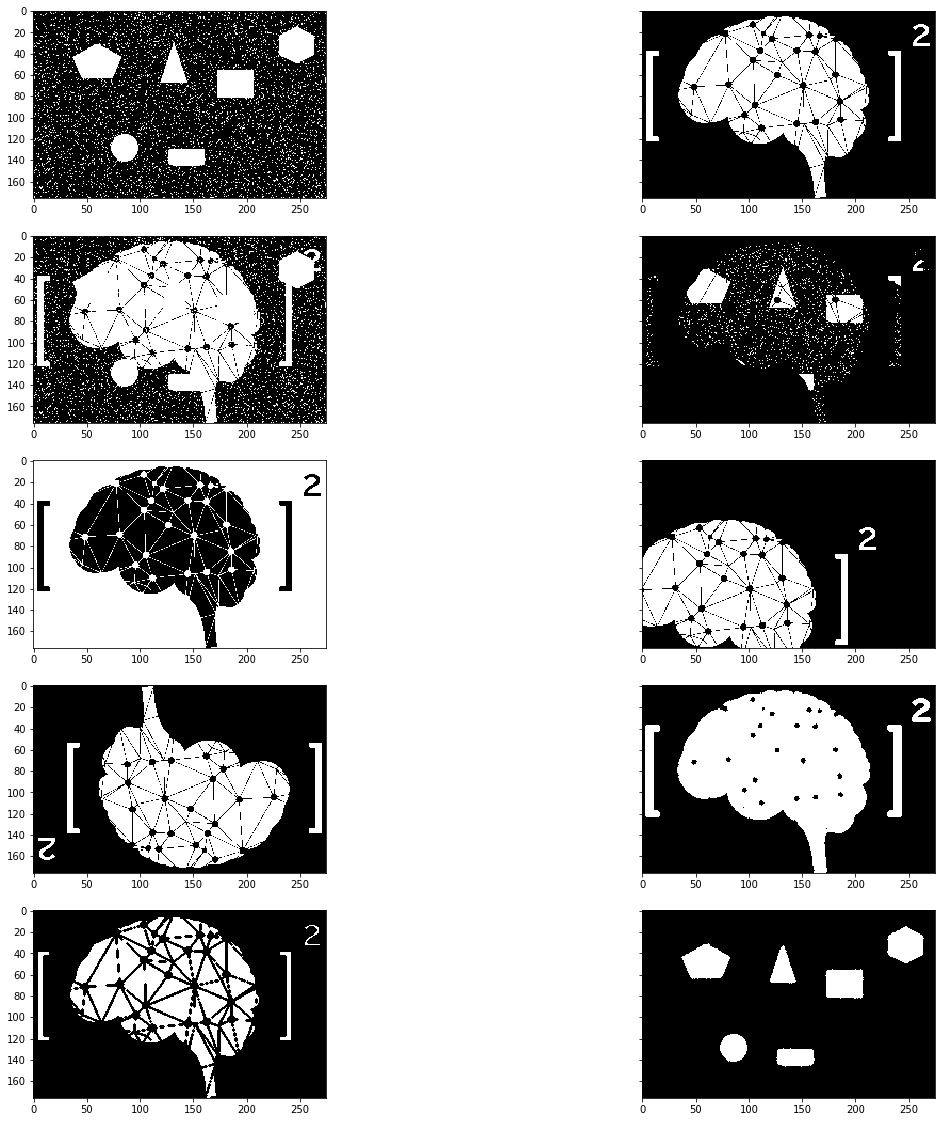

In [46]:
#-------------READING AND PREPARING IMAGES-------------#
binary_image1_name = "./binary/a_binary.png"
binary_image2_name = "./binary/b_binary.png"

binary_image1 = Image.open(binary_image1_name)
binary_image2 = Image.open(binary_image2_name)

binary_image1_array = np.asarray(binary_image1)
binary_image2_array = np.asarray(binary_image2)

if(validateSize(binary_image1_array, binary_image2_array) != True):
    sys.exit("Images are different size "+str(binary_image1_array.shape)+" vs "+str(binary_image2_array.shape))

bimage1 = removeChannels(binary_image1_array)
bimage2 = removeChannels(binary_image2_array)

bimage1 = thresholding(bimage1, 125)
bimage2 = thresholding(bimage2, 125)

bimage1 = putSaltNoise(bimage1, 10)
#-------------END OF READING AND PREPARING IMAGES-------------#


#UNION
print("\n\nCalculating union...")
%time bunion = union(bimage1, bimage2)


#INTERSECTION
print("\n\nCalculating intersection...")
%time bintersection = intersection(bimage1, bimage2)


#COMPLEMENT
print("\n\nCalculating complement...")
%time bcomplement = complement(bimage2)


#TRASLATION  (A)_b = {x | x = a+b}
print("\n\nCalculating traslation...")
b = [50, -50]
start_of_image = [0,0]
bimage2_set = getSet(bimage2, start_of_image)
%time btraslation_set = traslation(bimage2_set, b)
btraslation_image = compute_set_to_image(bimage2, btraslation_set, start_of_image)


#REFLECTION A' = {-x | x in A}
print("\n\nCalculating reflection...")
start_of_image = [88,137]
bimage2_set = getSet(bimage2, start_of_image)
%time breflection_set = reflection(bimage2_set)
breflection_image = compute_set_to_image(bimage2, breflection_set, start_of_image)


#DILATE A(+)B = { x | (B')_x intersection A != 0}
print("\n\nCalculating dilate...")
start_of_image = [0,0]
B = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype = np.uint8)
start_B = [1,1]

B_set = getSet(B, start_B)
B_reflected = reflection(B_set)
%time bdilate_image = dilate(bimage2, B_reflected)

print("\n\n\tCalculating dilate with distance transform...\n\t 1. DistanceTransform\n\t 2. Dilate with DT")
%time distanceTransform = distanceTransform_4N(bcomplement)
%time bdilate_image = dilateThresholding(distanceTransform, 1)



#ERODE A(-)B = {x | (B)_x subset A}
print("\n\nCalculating erode...")

B = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
], dtype = np.uint8)
start_B = [1,1]

B_set = getSet(B, start_B)
%time berode_image = erode(bimage2, B_set)
print("\n\n\tCalculating erode with distance transform...\n\t 1. DistanceTransform\n\t 2. Erode with DT")
%time distanceTransform = distanceTransform_4N(bimage2)
%time berode_image = thresholding(distanceTransform, 1)




# OPENING 

B = np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1]
], dtype = np.uint8)
B_start = [1,1]

B_set = getSet(B, B_start)
B_reflected = reflection(B_set)

print("\n\nCalculating opening...")
%time opening_erode = erode(bimage1, B_set)
%time opening = dilate(opening_erode, B_reflected)

print("\n\n\tCalculating opening transform 4 neighbours... \n\t 1. Dilance transform bimage1 \n\t 2. Erode DT \n\t 3. Complemente Erode DT \n\t 4. DT de Erode DT \n\t 5. Dilate DT")
%time distanceTransform = distanceTransform_4N(bimage1)
%time opening_erode = thresholding(distanceTransform, 1)
%time opening_erode = complement(opening_erode)
%time distanceTransform = distanceTransform_4N(opening_erode)
%time opening = dilateThresholding(distanceTransform, 1)





f, axarr = plt.subplots(5,2, figsize=(20,20), sharey=True)
axarr[0,0].imshow(bimage1, cmap = 'gray')
axarr[0,1].imshow(bimage2, cmap = 'gray')
axarr[1,0].imshow(bunion, cmap = 'gray')
axarr[1,1].imshow(bintersection, cmap = 'gray')
axarr[2,0].imshow(bcomplement, cmap = 'gray')
axarr[2,1].imshow(btraslation_image, cmap = 'gray')
axarr[3,0].imshow(breflection_image, cmap = 'gray')
axarr[3,1].imshow(bdilate_image, cmap = 'gray')
axarr[4,0].imshow(berode_image, cmap = 'gray')
axarr[4,1].imshow(opening, cmap = 'gray')
plt.show()

#test_image = np.array([
# [0,0,0,0,0,0,0,0,0],
# [0,0,0,0,0,0,0,0,0],
# [0,1,1,1,1,1,0,0,0],
# [0,1,1,1,1,1,0,0,0],
# [0,1,1,1,1,1,0,1,0],
# [0,1,1,1,1,1,0,1,0],
# [0,1,1,1,1,1,0,1,0],
# [0,0,0,0,1,1,1,1,0],
# [0,0,0,0,1,0,0,0,0],
# [0,0,0,0,1,1,0,0,0],
# [0,0,0,0,0,0,0,0,0]
# ], dtype = np.uint8)

# test_image = np.array([
#     [1,1,1,1,1],
#     [1,1,1,1,1],
#     [1,1,0,1,1],
#     [1,1,1,1,1],
#     [1,1,1,1,1]
# ], dtype = np.uint8)

# distanceTransform = distanceTransform_4N(test_image)
# print("\n\n4 NEIGBOURS: \n\n",distanceTransform)

# distanceTransform = distanceTransform_8N(test_image)
# print("\n\n8 NEIGBOURS: \n\n", distanceTransform)